# 1. Import Dependencies

In [1]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# 2. Data Preprocessing

In [2]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

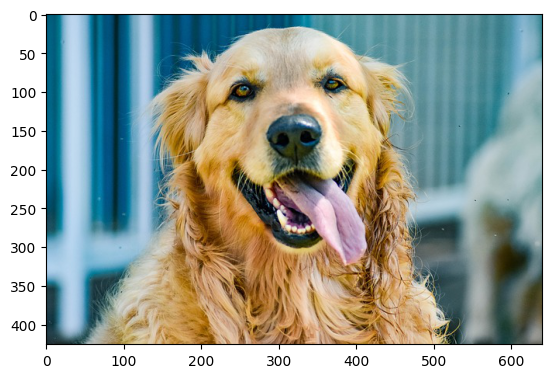

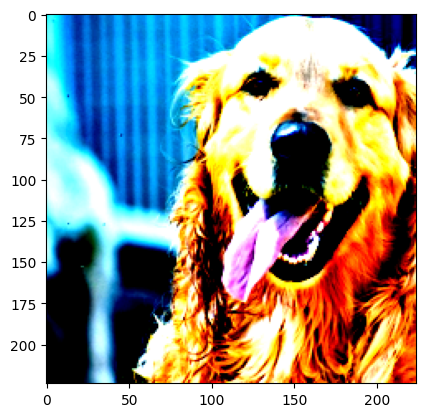

In [5]:
image_file_path = './pytorch_advanced/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase = 'train')

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

# 3. Import Dataset

In [6]:
def make_datapath_list(phase='train'):
    rootpath = './pytorch_advanced/1_image_classification/data/hymenoptera_data/'
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

print(train_list)

./pytorch_advanced/1_image_classification/data/hymenoptera_data/train/**/*.jpg
./pytorch_advanced/1_image_classification/data/hymenoptera_data/val/**/*.jpg
['./pytorch_advanced/1_image_classification/data/hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg', './pytorch_advanced/1_image_classification/data/hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg', './pytorch_advanced/1_image_classification/data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg', './pytorch_advanced/1_image_classification/data/hymenoptera_data/train/bees/2962405283_22718d9617.jpg', './pytorch_advanced/1_image_classification/data/hymenoptera_data/train/bees/446296270_d9e8b93ecf.jpg', './pytorch_advanced/1_image_classification/data/hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg', './pytorch_advanced/1_image_classification/data/hymenoptera_data/train/bees/2704348794_eb5d5178c2.jpg', './pytorch_advanced/1_image_classification/data/hymenoptera_data/train/bees/2358061370_9daabbd9ac.jpg', './pytorch_ad

In [39]:
class HymenopteraDataset(data.Dataset):
    def __init__(self, file_list, transform = None, phase = 'train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        if self.phase == 'train':
            label = img_path[70:74]
        elif self.phase == 'val':
            label = img_path[68:72]
            
        if label == 'ants':
            label = 0
        elif label == 'bees':
            label = 1
            
        return img_transformed, label

In [40]:
train_dataset = HymenopteraDataset(
    file_list = train_list, transform = ImageTransform(size, mean, std), phase = 'train')
val_dataset = HymenopteraDataset(
    file_list = val_list, transform = ImageTransform(size, mean, std), phase = 'val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1


# 4. Create Data Loader

In [41]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size = batch_size, shuffle = False)

dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(
    batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0])


# 5. Create a Model

In [43]:
use_pretrained = True
net = models.vgg16(pretrained = use_pretrained)

net.classifier[6] = nn.Linear(in_features = 4096, out_features = 2)

net.train()

print('network setting completed.')

network setting completed.


In [44]:
criterion = nn.CrossEntropyLoss()

In [47]:
params_to_update = []

update_param_names = ['classifier.6.weight', 'classifier.6.bias']

for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

print('-'*20)
print(params_to_update)

classifier.6.weight
classifier.6.bias
--------------------
[Parameter containing:
tensor([[-1.0264e-02,  2.2879e-03, -6.7586e-03,  ...,  1.1743e-02,
         -6.8285e-05,  1.0507e-02],
        [ 1.2393e-02, -5.0637e-03, -3.2901e-03,  ..., -5.9535e-03,
         -7.8233e-03,  1.0299e-02]], requires_grad=True), Parameter containing:
tensor([0.0095, 0.0010], requires_grad=True)]


In [48]:
optimizer = optim.SGD(params = params_to_update, lr = 0.001, momentum = 0.9)

# 6. Training and Validation

In [49]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-'*20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            if (epoch == 0) and (phase == 'train'):
                continue
                
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
                    epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
                    epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
                    
                    print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')

In [50]:
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs)

Epoch 1/2
--------------------


 20%|█████████                                    | 1/5 [00:05<00:21,  5.47s/it]

val Loss: 0.1385274151571436 Acc: 0.12418300653594772


 40%|██████████████████                           | 2/5 [00:10<00:15,  5.02s/it]

val Loss: 0.1356443799266679 Acc: 0.26143790849673204


 60%|███████████████████████████                  | 3/5 [00:14<00:09,  4.83s/it]

val Loss: 0.17386350096488146 Acc: 0.32679738562091504


 80%|████████████████████████████████████         | 4/5 [00:19<00:04,  4.86s/it]

val Loss: 0.18176748920507838 Acc: 0.3790849673202614


100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.71s/it]


val Loss: 0.14706765414381778 Acc: 0.45098039215686275
Epoch 2/2
--------------------


 12%|█████▋                                       | 1/8 [00:05<00:35,  5.03s/it]

train Loss: 0.1147555049064228 Acc: 0.06584362139917696


 25%|███████████▎                                 | 2/8 [00:09<00:29,  4.90s/it]

train Loss: 0.09481317758879154 Acc: 0.12757201646090535


 38%|████████████████▉                            | 3/8 [00:14<00:23,  4.73s/it]

train Loss: 0.09376747548336195 Acc: 0.19753086419753085


 50%|██████████████████████▌                      | 4/8 [00:19<00:19,  4.77s/it]

train Loss: 0.07326485717982398 Acc: 0.2962962962962963


 62%|████████████████████████████▏                | 5/8 [00:23<00:14,  4.72s/it]

train Loss: 0.06282322012694164 Acc: 0.40329218106995884


 75%|█████████████████████████████████▊           | 6/8 [00:28<00:09,  4.69s/it]

train Loss: 0.043327527461690975 Acc: 0.522633744855967


 88%|███████████████████████████████████████▍     | 7/8 [00:33<00:04,  4.71s/it]

train Loss: 0.036093940285245756 Acc: 0.6337448559670782


100%|█████████████████████████████████████████████| 8/8 [00:36<00:00,  4.53s/it]


train Loss: 0.013099930188895418 Acc: 0.7119341563786008


 20%|█████████                                    | 1/5 [00:05<00:21,  5.29s/it]

val Loss: 0.042532783707762076 Acc: 0.19607843137254902


 40%|██████████████████                           | 2/5 [00:11<00:16,  5.63s/it]

val Loss: 0.03989582034472017 Acc: 0.39869281045751637


 60%|███████████████████████████                  | 3/5 [00:17<00:11,  5.84s/it]

val Loss: 0.040096038617114055 Acc: 0.5947712418300654


 80%|████████████████████████████████████         | 4/5 [00:23<00:05,  5.83s/it]

val Loss: 0.027652514487553136 Acc: 0.803921568627451


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.40s/it]

val Loss: 0.03118180262828216 Acc: 0.9607843137254902
